# CS 542 Fall 2024 Midterm

Your task for this midterm is to build a model detecting trees in images.
This repository includes approximately 500 pictures.
Most of them are from the Boston area, but some are from around the globe.
Most of them were taken outside, but some were taken inside or in more exotic locations.
Many other factors such as lighting, weather, and confounding bushes will make this a challenging problem.

* 70% of the grade will be based on the model that you build.
  * This portion of the grade will heavily driven by your model's performance on the test data.
* 30% will be based on answering questions about your model and your process.

The baseline code has trouble consistently achieving 70% accuracy on the validation set.
* If you achieve 75% accuracy on the test set, that will be worth at least 80% for the model component of your grade.
* If you achieve 80% accuracy on the test set, that will be worth at least 90% for the model component of your grade.

When you are done, submit both this notebook and the output file of test predictions to Gradescope.

In [1]:
!pip install --quiet imageio livelossplot torcheval

    yapf (>='0.28') ; python_version < "3.6"
         ~^


In [26]:
import imageio.v2 as imageio
import livelossplot
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torcheval.metrics
from torchvision import transforms, models
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [27]:
def to_gpu(t):
    if torch.cuda.is_available():
        return t.cuda()
    return t

def to_numpy(t):
    return t.detach().cpu().numpy()

device = to_gpu(torch.ones(1,1)).device
device

device(type='cuda', index=0)

## Model Building (70 points)

Change any of the code below to build a better model.
Your model will primarily be graded on predictions on the test set.
Be sure to include your model's test predictions when you submit to Gradescope.

In [28]:
# the repository has images scaled to standard widths of 64, 128 and 256.
# you may use larger images if you prefer.

image_width = 256

# Data augmentation to help generalize better (toned down version)
data_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomHorizontalFlip(),  # Random horizontal flip
    # transforms.RandomVerticalFlip(),    # Random vertical flip
    # transforms.RandomResizedCrop(image_width, scale=(0.8, 1.0)),  # Random resized crop
    transforms.RandomRotation(degrees=15),  # Random rotation with up to ±15 degrees
    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # Color jitter for brightness, contrast, saturation, and hue
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),  # Random Gaussian blur with probability 0.3
    transforms.Resize((image_width, image_width))
])

In [29]:
def load_data_set(data_set_name):
    labels = pd.read_csv(f"{data_set_name}.tsv", sep="\t")

    file_names = []
    images = []
    targets = []
    for i in range(labels.shape[0]):
        row = labels.iloc[i]
        try:
            image = imageio.imread(f"images{image_width}/{row['filename']}")[...]
        except:
            print("SKIPPING ", row['filename'], "MISSING")
            continue

        if image.shape[0] != image.shape[1] * 3 // 4:
            print("SKIPPING ", row['filename'], image.shape)
            continue

        # convert from 0-255 to 0.0-1.0
        image = image / 255
        # prepend axis with length one
        # image = image.reshape(1, *image.shape)
        image = torch.Tensor(image).to(device)
        # permute image dimensions to put color channel first
        image = torch.permute(image, [2, 0, 1])
        # # Convert to PIL image for transformation
        # image = transforms.functional.to_pil_image(image)
        # # Apply the transformations
        # image = data_transform(image)

        file_names.append(row['filename'])
        images.append(image)
        targets.append(row["target"])

    images = torch.stack(images)#.to(device)

    targets = torch.Tensor(targets).to(device)
    targets = targets.long()

    return (file_names, images, targets)

train_data_set = load_data_set("train")
for t in train_data_set[1:]:
    print("TRAIN", t.shape, t.dtype)
(train_file_names, train_X, train_Y) = train_data_set

validation_data_set = load_data_set("validation")
for t in validation_data_set[1:]:
    print("VALIDATION", t.shape, t.dtype)
(validation_file_names, validation_X, validation_Y) = validation_data_set

SKIPPING  IMG_1026.png MISSING
SKIPPING  IMG_1105.png MISSING
SKIPPING  IMG_1106.png MISSING
SKIPPING  IMG_1109.png MISSING
SKIPPING  IMG_1110.png MISSING
SKIPPING  IMG_1111.png MISSING
SKIPPING  IMG_1116.png MISSING
SKIPPING  IMG_1119.png MISSING
TRAIN torch.Size([292, 3, 192, 256]) torch.float32
TRAIN torch.Size([292]) torch.int64
SKIPPING  IMG_1107.png MISSING
SKIPPING  IMG_1112.png MISSING
SKIPPING  IMG_1117.png MISSING
VALIDATION torch.Size([97, 3, 192, 256]) torch.float32
VALIDATION torch.Size([97]) torch.int64


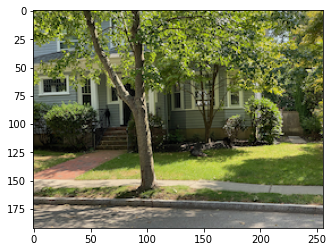

In [30]:
plt.imshow(to_numpy(torch.permute(train_X[0,:,:,:], (1, 2, 0))))

In [31]:
class BasicBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.dropout = torch.nn.Dropout2d(0.5)  # Adding Dropout to avoid overfitting

        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)  # Apply Dropout after first conv layer
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [32]:
class ResNet18(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.relu = torch.nn.ReLU(inplace=True)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [33]:
class TreeNetwork(ResNet18):
    def __init__(self):
        super(TreeNetwork, self).__init__(num_classes=2)
        self.to(device)

test_model = TreeNetwork()
test_output = test_model(train_X[:5])
assert test_output.shape == (5, 2)
del test_output

In [34]:
loss_function = torch.nn.CrossEntropyLoss()

In [35]:
DEFAULT_EPOCHS = 1000 if torch.cuda.is_available() else 100

def train_model(model_class, epochs=DEFAULT_EPOCHS, learning_rate=1e-4, batch_size=32, **kwargs):
    model = model_class(**kwargs)
    try:
        model = model.cuda()
    except:
        print("cuda() failed")
    model = torch.nn.DataParallel(model)
    model.train()

    # Create DataLoader for mini-batch training
    train_dataset = TensorDataset(train_X, train_Y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    liveloss = livelossplot.PlotLosses()
    for i in range(epochs):
        model.train()

        optimizer.zero_grad(set_to_none=True)
        prediction = model(train_X)
        loss = loss_function(prediction, train_Y)
        loss.backward()
        optimizer.step()

        if (i + 1) % 2 == 0:
            liveloss_updates = {}
            with torch.no_grad():
                model.eval()

                def get_metrics(metrics_prefix, metrics_X, metrics_Y):
                    metrics_prediction = model(metrics_X)

                    return {
                        f"{metrics_prefix}loss": loss_function(metrics_prediction, metrics_Y),
                        f"{metrics_prefix}accuracy": torcheval.metrics.functional.multiclass_accuracy(torch.argmax(metrics_prediction, dim=-1), metrics_Y)
                    }
                
                liveloss_updates.update(get_metrics("", train_X, train_Y))
                liveloss_updates.update(get_metrics("val_", validation_X, validation_Y))

            liveloss_updates = {k: to_numpy(v) for k, v in liveloss_updates.items()}
            liveloss.update(liveloss_updates,
                            current_step=i+1)
            liveloss.send()

    return model

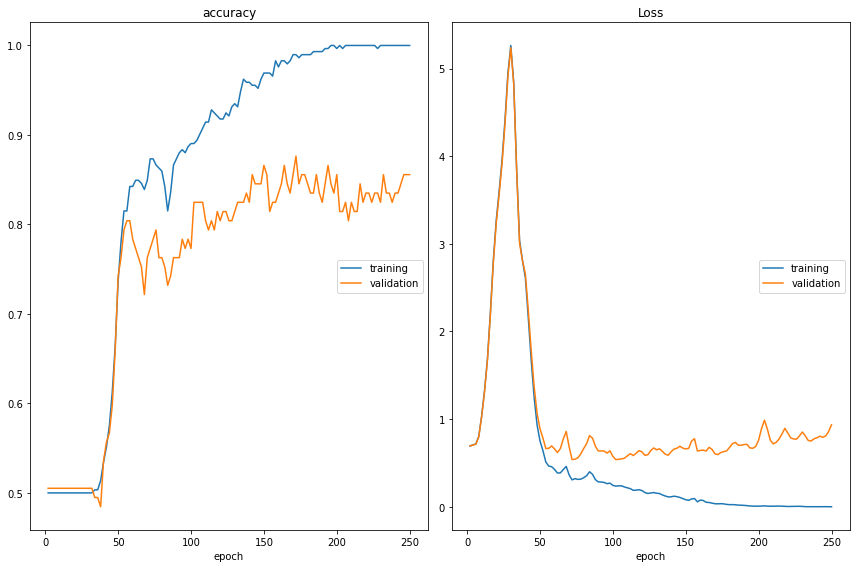

accuracy
	training         	 (min:    0.500, max:    1.000, cur:    1.000)
	validation       	 (min:    0.485, max:    0.876, cur:    0.856)
Loss
	training         	 (min:    0.001, max:    5.263, cur:    0.001)
	validation       	 (min:    0.538, max:    5.237, cur:    0.936)


In [36]:
tree_model = train_model(TreeNetwork, epochs=250, learning_rate=1e-4, batch_size=16)

In [37]:
# Save the best model
torch.save(tree_model.state_dict(), 'best_model.pth')
print("Model saved successfully as 'best_model.pth'")

Model saved successfully as 'best_model.pth'


In [38]:
test_data_set = load_data_set("test")
(test_file_names, test_X, test_Y) = test_data_set

SKIPPING  IMG_1108.png (342, 256, 3)
SKIPPING  IMG_1113.png (342, 256, 3)
SKIPPING  IMG_1118.png (342, 256, 3)


In [39]:
with torch.no_grad():
    tree_model.eval()

    test_prediction = tree_model(test_X)

test_prediction = to_numpy(test_prediction)
with open("test-output.tsv", "w") as test_fp:
    test_fp.write("filename\tlogit_0\tlogit_1\tprediction\n")

    for (test_filename, (logit_0, logit_1)) in zip(test_file_names, test_prediction):
        prediction = 1 if logit_1 > logit_0 else 0
        test_fp.write(f"{test_filename}\t{logit_0:.6f}\t{logit_1:.6f}\t{prediction}\n")

In [40]:
!head test-output.tsv

filename	logit_0	logit_1	prediction
IMG_0184.png	5.553199	-4.233638	0
IMG_0204.png	5.026330	-3.688700	0
IMG_0209.png	0.511383	0.347799	0
IMG_0296.png	6.166064	-4.832025	0
IMG_0319.png	3.480272	-2.419356	0
IMG_0331.png	4.259497	-3.149021	0
IMG_0369.png	-3.446909	3.707371	1
IMG_0437.png	5.367981	-3.982699	0
IMG_0585.png	7.500154	-5.688869	0


### What aspects of your model design helped fit the training the data the most? (10 points)

How did you change the base model to fit the training data better?
More quickly?
Can you quantify the benefits of those changes?

## Questions

YOUR ANSWER HERE

1. Model Redesign to ResNet18: The original network showed clear signs of overfitting, even after implementing data augmentation (e.g., flipping, rotation, brightness adjustments, and Gaussian blur). As these techniques provided only modest improvements, I switched to using ResNet18, a more advanced architecture designed for image recognition tasks.

    - BasicBlock Design: ResNet18 uses a series of BasicBlocks, each containing two convolutional layers with batch normalization and ReLU activation, as well as a shortcut connection that helps maintain gradient flow and stabilize training. A dropout layer with a 0.5 probability was added to combat overfitting.
    - Deeper Network: The ResNet18 model is composed of four main layers, each with different numbers of BasicBlocks to deepen the network, enabling it to learn more complex features. This deeper architecture helped the model achieve better feature extraction, particularly useful for diverse images in this dataset.

2. I increased the image resolution to 256 pixels. This gave the model more detailed information, which helped it better capture subtle distinctions between features, such as leaves and branches.

3. Learning Rate Adjustment: I reduced the learning rate to 1e-4, which helped the model learn in a more stable manner. A lower learning rate prevented the model from making large, destabilizing weight updates, contributing to smoother convergence.

4. Mini-Batch Training: I employed mini-batch training with a batch size of 16, which enhanced training efficiency and stability.


### What did you do to manage overfitting? (10 points)

Please elaborate on your model design choices to reduce overfitting.
How much did these choices appear to help?

YOUR ANSWER HERE

Initially, I tried data augmentation techniques, but they did not show significant improvements. To further manage overfitting, I added a Dropout layer with a probability of 0.5 after the first convolutional layers in the BasicBlock. This helped by randomly dropping neurons during training, reducing overfitting.

Instead of using early stopping, I manually adjusted the number of epochs after observing the training and validation accuracy and loss graphs. I reduced the epochs to prevent overfitting, especially when I noticed the training loss was low while the validation loss started to show signs of increase.

Moreover, switching to ResNet18 helped manage overfitting. Considering the dataset contained only around 500 images, I chose ResNet18 instead of deeper variants like ResNet200. A deeper model would have likely led to overfitting given the limited dataset size.

### In your opinion, what factor held back your model performance the most? (5 points)

YOUR ANSWER HERE

The small dataset size (less than 500 images) significantly limits the ability of the model to generalize.

Additionally, the diversity in image types (e.g., lighting conditions, indoor vs. outdoor, different seasons) makes it challenging for the model to capture all possible variations effectively without more data.

### If you were given an extra week to work on this model, what would you do? (2 points)

YOUR ANSWER HERE

I would try transfer learning using a pre-trained model like ResNet18 or ResNet200, which has been trained on a large-scale dataset such as ImageNet. This approach can help the model learn general image features effectively and quickly adapt to the tree classification task with fine-tuning.

### What was the most interesting image in the data set that you noticed? (3 points)

Do you think it made the modeling process easier or harder?

YOUR ANSWER HERE

The most interesting image I noticed was IMG_8554.png. This image does not contain a typical tree but instead shows small seedlings or saplings. It's unclear if they are young trees or simply garden plants, but from a distance, they could easily be mistaken for small trees due to their shape. This type of image is deceptive, as it closely resembles tree-like features without actually being a tree. Such misleading visuals make it challenging for the model to accurately learn tree-specific features, increasing the difficulty of training.